In [1]:
from networks.UNet import LitUNet
from lightning import Trainer
# from torch.nn.functional import softmax
import os
# from skimage.io import imread
import numpy as np
import matplotlib.pyplot as plt
# import torch
from glob import glob
from data.dataset import OEMDataset
from torch.utils.data import DataLoader
from pathlib import Path

In [2]:
# map_location = {'cuda:0':'cpu'}
ckpt_pth = glob('/home/ubuntu/hrl/high-res-lulc/.neptune/Untitled/LUL-55/checkpoints/*.ckpt')
model = LitUNet.load_from_checkpoint(checkpoint_path=ckpt_pth[0], map_location='cpu')
trainer = Trainer(accelerator='gpu',num_nodes=1)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/opt/conda/envs/pytorch/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/logger_connector/logger_connector.py:75: Starting from v1.9.0, `tensorboardX` has been removed as a dependency of the `lightning.pytorch` package, due to potential conflicts with other packages in the ML ecosystem. For this reason, `logger=True` will use `CSVLogger` as the default logger, unless the `tensorboard` or `tensorboardX` packages are found. Please `pip install lightning[extra]` or one of them to enable TensorBoard support by default


In [3]:
DATA_DIR = "/home/ubuntu/hrl/high-res-lulc/data/processing"
VAL_LIST = os.path.join(DATA_DIR, "val.txt")
fns = [f for f in Path(DATA_DIR).rglob("*png") if "/images/" in str(f)]
print(len(fns))
fns = [f for f in fns if os.path.exists(str(f).replace('/images/', '/labels/'))]
print(len(fns))
val_list = [str(f)
            for f in fns
            if "_".join(f.name.split("_")[:-2]) + ".tif"
            in np.loadtxt(VAL_LIST, dtype=str)
        ]

59194
43629


In [4]:
val_list = val_list[:100]

In [5]:
def pred_labels(trainer, dataloader):
    preds = trainer.predict(model, dataloaders=dataloader)
    # preds = torch.argmax(softmax(input=preds, dim=1), dim=1).permute(1,2,0).numpy()
    return preds

In [6]:
OEM_pred = DataLoader(OEMDataset(img_list=val_list, testing=False, augm=None), shuffle=False)

In [7]:
pred_labels = pred_labels(trainer=trainer, dataloader=OEM_pred)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/opt/conda/envs/pytorch/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.


Predicting: |          | 0/? [00:00<?, ?it/s]

/opt/conda/envs/pytorch/lib/python3.10/site-packages/torch/nn/modules/module.py:1518: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


In [8]:
true = np.concatenate([preds[1].flatten() for preds in pred_labels])
pred = np.concatenate([preds[0].flatten() for preds in pred_labels])

In [9]:
import seaborn as sns
import pandas as pd

In [10]:

from sklearn.metrics import confusion_matrix
cm = confusion_matrix(true, pred, normalize='true')

In [11]:
np.unique(true, return_counts=True)

(array([0, 1, 2, 3, 4, 5, 6, 7, 8]),
 array([  15720,    3403, 1456500, 1068433,  417326, 1468060,  224275,
        1265688,  634195]))

In [12]:
np.unique(pred, return_counts=True)

(array([2, 3, 5, 6, 7, 8]),
 array([1386008, 1246033, 1480109,  395571, 1389174,  656705]))

In [13]:
list(np.unique([true, pred]))

[0, 1, 2, 3, 4, 5, 6, 7, 8]

In [14]:
# Creating a dataframe for a array-formatted Confusion matrix,so it will be easy for plotting.
cm_df = pd.DataFrame(cm,
                     index = list(np.unique([true, pred])), 
                     columns = list(np.unique([true, pred]))
                     )

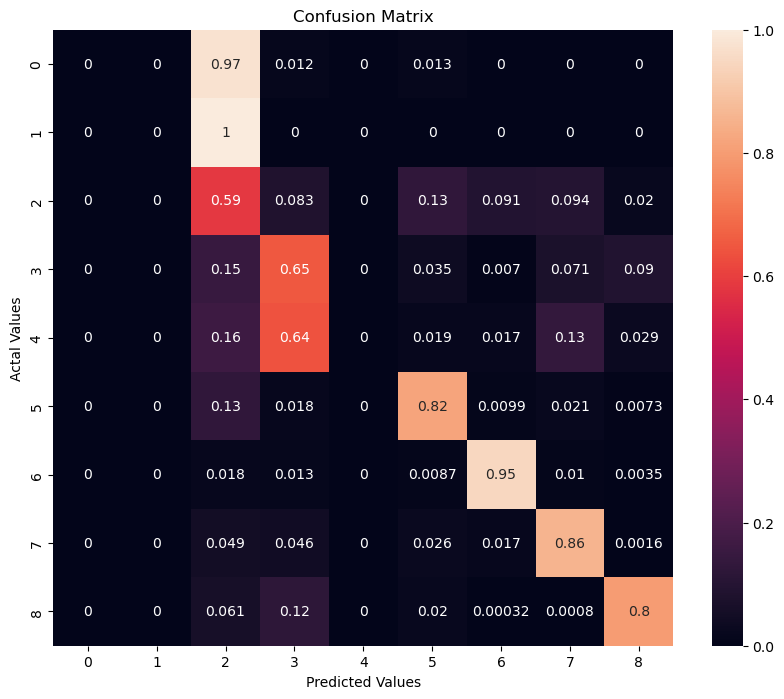

In [15]:
#Plotting the confusion matrix
plt.figure(figsize=(10,8))
sns.heatmap(cm_df, annot=True)
plt.title('Confusion Matrix')
plt.ylabel('Actal Values')
plt.xlabel('Predicted Values')
plt.show()

In [ ]:
from sklearn.metrics import precision_recall_fscore_support

In [ ]:
scores = precision_recall_fscore_support(true, pred, labels=list(np.unique([true, pred])))

In [ ]:
precisions = scores[0]
recalls = scores[1]
f1s = scores[2]

In [ ]:
precisions

In [ ]:
recalls

In [ ]:
f1s

In [ ]:
list(np.unique([true, pred]))